In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import glob
import h5py
import fsspec
import math
from scipy import signal
from pyproj import Proj, CRS
import matplotlib.pyplot as plt
import shapely.wkt as wkt
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_origin
from rasterio import merge
import folium
from folium import plugins
import rioxarray
import matplotlib as mpl
import sys

import warnings
warnings.filterwarnings('ignore')

#### SJV

In [3]:
sys.path.append('../../')
from src.cslc_utils import read_cslc, cslc_info, rasterWrite, custom_merge, colorize, getbasemaps, moving_window_mean

In [4]:
path_1 = '/u/trappist-r0/kdevlin/work/CSLC/Tulare/D144/stack/t144_308014_iw2/t144_308014_iw2/20170601/t144_308014_iw2_20170601.h5'
path_2 = '/u/trappist-r0/kdevlin/work/CSLC/Tulare/D144/stack/t144_308014_iw2/t144_308014_iw2/20170613/t144_308014_iw2_20170613.h5'

In [5]:
#data_dir = 's3://opera-pst-rs-pop1/products/cslc_historical_20190701_to_20190718/' #ALH chng
burst_id = ['t144_308014_iw2'] #ALH chng
#burst_id = ['t071_151217_iw2', 't071_151218_iw2']  #Test for at least 2 burst_ids
date = ['20170601', '20170613'] #ALH chng
save_fn = f'TEST_{date[1]}-{date[0]}_{burst_id[0][:4]}.tif'

In [6]:
# Read before and after event dataset 
before = []; after = []  

for id in burst_id:
    path_h5 = path_1 #ALH chng
    # path_h5 = f'{data_dir}/{id}/{date[0]}/{id}_{date[0]}.h5' 

    dat = read_cslc(path_h5)
    before.append(dat)

for id in burst_id:
    path_h5 = path_2 #ALH chng
    # path_h5 = f'{data_dir}/{id}/{date[1]}/{id}_{date[1]}.h5' 
    dat = read_cslc(path_h5)
    after.append(dat)

Opening: /u/trappist-r0/kdevlin/work/CSLC/Tulare/D144/stack/t144_308014_iw2/t144_308014_iw2/20170601/t144_308014_iw2_20170601.h5


Opening: /u/trappist-r0/kdevlin/work/CSLC/Tulare/D144/stack/t144_308014_iw2/t144_308014_iw2/20170613/t144_308014_iw2_20170613.h5


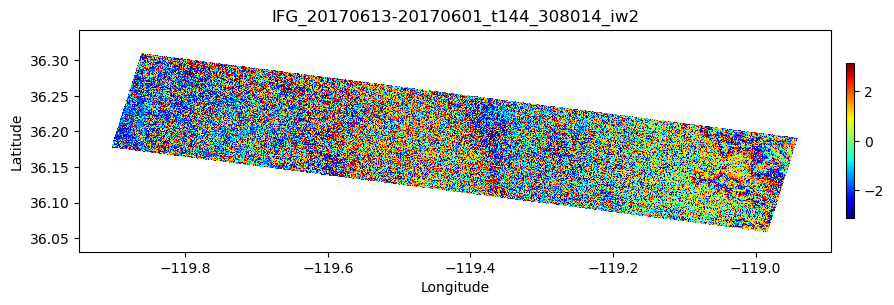

In [7]:
%matplotlib inline

for i, id in enumerate(burst_id):
    # xcoor, ycoor, dx, dy, epsg, bounding_polygon, orbit_direction = cslc_info(f'{data_dir}/{id}/{date[0]}/{id}_{date[0]}.h5')
    xcoor, ycoor, dx, dy, epsg, bounding_polygon, orbit_direction = cslc_info(path_1) #ALH chng

    cslc_poly = wkt.loads(bounding_polygon)
    bbox = [cslc_poly.bounds[0], cslc_poly.bounds[2], cslc_poly.bounds[1], cslc_poly.bounds[3]]

    # Calculate burst-wise interferogram
    ifg = after[i] * np.conj(before[i])
    
    # Plot each interferogram
    fig, ax = plt.subplots(figsize=(10,3))
    cax = ax.imshow(colorize(np.angle(ifg), 'jet', -np.pi, np.pi), cmap='jet',interpolation='nearest', origin='upper',extent=bbox, vmin=-np.pi, vmax=np.pi)
    plt.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'IFG_{date[1]}-{date[0]}_{id}',fontsize=12)
    
after = []; before=[]

In [8]:
ifg_cpx = np.exp(1j * np.nan_to_num(np.angle(ifg)))

In [9]:
stdrg = 5
stdaz = 5
kernlenrg = 3*stdrg+1
kernlenaz = 3*stdaz+1
gkernrg = signal.gaussian(kernlenrg, std=stdrg).reshape(kernlenrg, 1)
gkernaz = signal.gaussian(kernlenaz, std=stdaz).reshape(kernlenaz, 1)
gwind2d = np.outer(gkernaz, gkernrg)
gwind2d = gwind2d/np.sum(gwind2d)

In [10]:
# rectangular window
rx = 10
ry = 10

windx = np.zeros((1,rx*2+1))
windx[0,rx-math.floor(rx/2) + np.arange(1,rx)]=1
windy = np.zeros((1,ry*2+1))
windy[0,ry-math.floor(ry/2) + np.arange(1,ry)]=1
windx = windx/np.sum(windx)
windy = windy/np.sum(windy)
bwind2d = windy.T*windx


In [11]:
nan_mask = np.isnan(ifg)
zero_mask = ifg == 0

In [12]:
# full res coherence
# a   = before[0]*np.conj(before[0])
# b   = after[0]*np.conj(after[0])
#merged_ifg   = before*np.conj(after)
#ca  = abs(merged_ifg)      
# asum = signal.convolve2d(a, gwind2d, mode='same')
# bsum = signal.convolve2d(b, gwind2d, mode='same')
csum = signal.convolve2d(ifg_cpx, gwind2d, mode='same')
#cmag = signal.convolve2d(ca, wind2d, mode='same')  
#cpx3 = csum/np.sqrt(asum*bsum) #alternative def of coherence
#cpx3 = csum/cmag
gcoh   = abs(csum)
gcoh[np.isnan(gcoh)] = 0

In [13]:
# full res coherence
# a   = before[0]*np.conj(before[0])
# b   = after[0]*np.conj(after[0])
#merged_ifg   = before*np.conj(after)
#ca  = abs(merged_ifg)      
# asum = signal.convolve2d(a, gwind2d, mode='same')
# bsum = signal.convolve2d(b, gwind2d, mode='same')
csum = signal.convolve2d(ifg_cpx, bwind2d, mode='same')
#cmag = signal.convolve2d(ca, wind2d, mode='same')  
#cpx3 = csum/np.sqrt(asum*bsum) #alternative def of coherence
#cpx3 = csum/cmag
bcoh   = abs(csum)
bcoh[np.isnan(bcoh)] = 0

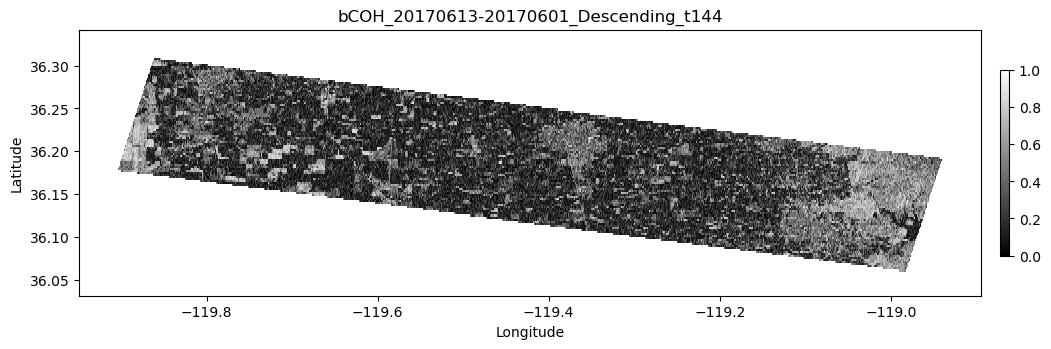

In [14]:
bcoh[nan_mask] = np.nan
bcoh[zero_mask] = 0

# Downsample for folium visualization and attach RGBA color to numpy array
colored_bcoh = colorize(bcoh[::6][::6], 'gray', 0., 1)

# Plot
fig, ax = plt.subplots(figsize=(12,9))
cax = ax.imshow(colored_bcoh, cmap='gray',interpolation='nearest', origin='upper',extent=bbox, vmin=0, vmax=1.)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'bCOH_{date[1]}-{date[0]}_{orbit_direction}_{burst_id[0][:4]}',fontsize=12)
fig.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
plt.show()

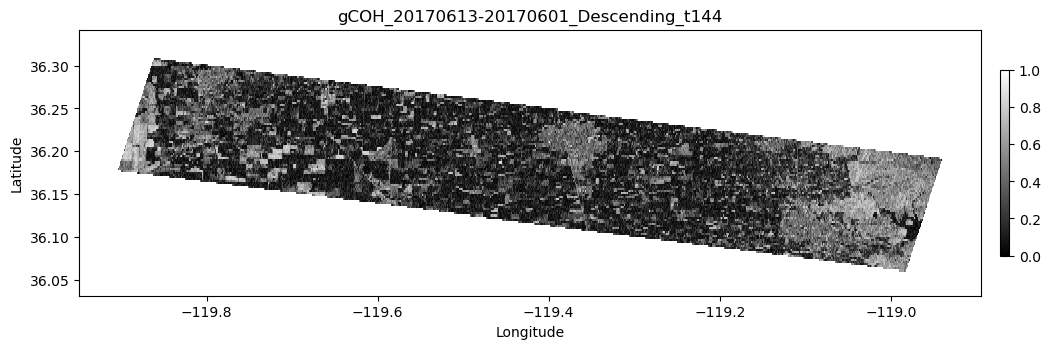

In [15]:
gcoh[nan_mask] = np.nan
gcoh[zero_mask] = 0

# Downsample for folium visualization and attach RGBA color to numpy array
colored_gcoh = colorize(gcoh[::6][::6], 'gray', 0., 1)

# Plot
fig, ax = plt.subplots(figsize=(12,9))
cax = ax.imshow(colored_gcoh, cmap='gray',interpolation='nearest', origin='upper',extent=bbox, vmin=0, vmax=1.)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'gCOH_{date[1]}-{date[0]}_{orbit_direction}_{burst_id[0][:4]}',fontsize=12)
fig.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
plt.show()

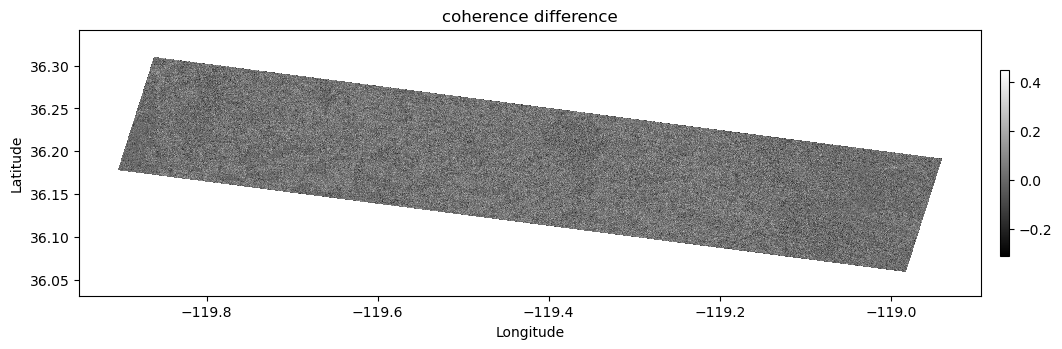

In [16]:
colored_diffcoh = colorize(bcoh[::6][::6]-gcoh[::6][::6], 'gray', 0., 1)

# Plot
fig, ax = plt.subplots(figsize=(12,9))
cax = ax.imshow(bcoh-gcoh, cmap='gray',interpolation='nearest', origin='upper',extent=bbox)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('coherence difference',fontsize=12)
fig.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
plt.show()


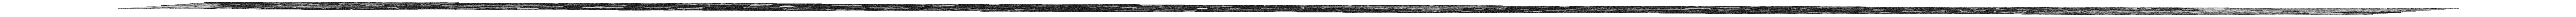
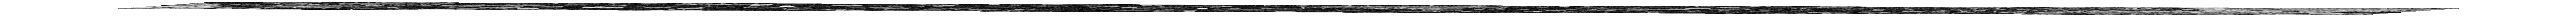
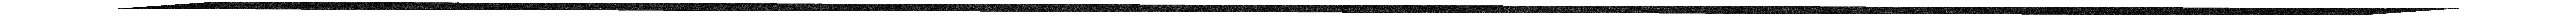

In [17]:
# Overlay merged bursts onto a basemap.
# Initialize Folium basemap and define center of mapview
xmid =(bbox[0]+bbox[1])/2 ; ymid = (bbox[2]+bbox[3])/2
m = folium.Map(location=[ymid, xmid], zoom_start=9, tiles='Stamen Terrain', show=True)

# Add custom basemaps
basemaps = getbasemaps()
for basemap in basemaps:
    basemaps[basemap].add_to(m)

# Overlay merged interferogram on a basemap
folium.raster_layers.ImageOverlay(colored_bcoh, 
                                        opacity=1.0, 
                                        bounds=[[bbox[2],bbox[0]],[bbox[3],bbox[1]]],
                                        interactive=False,
                                        name='boxcar',
                                        show=True).add_to(m)

# Include coherence as a layer
folium.raster_layers.ImageOverlay(colored_gcoh, 
                                        opacity=1.0, 
                                        bounds=[[bbox[2],bbox[0]],[bbox[3],bbox[1]]],
                                        interactive=False,
                                        name='Gaussian',
                                        show=True).add_to(m)

# Include coherence as a layer
folium.raster_layers.ImageOverlay(colored_diffcoh, 
                                        opacity=1.0, 
                                        bounds=[[bbox[2],bbox[0]],[bbox[3],bbox[1]]],
                                        interactive=False,
                                        name='Coherence Diff',
                                        show=True).add_to(m)

#layer Control
m.add_child(folium.LayerControl())

# Add fullscreen button
plugins.Fullscreen().add_to(m)

#Add inset minimap image
minimap = plugins.MiniMap(width=300, height=300)
m.add_child(minimap)

#Mouse Position
fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
plugins.MousePosition(position='bottomright', separator=' | ', prefix="Lat/Lon:",
                     lat_formatter=fmtr, lng_formatter=fmtr).add_to(m)

#Display
m